In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
from importlib import reload
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

291745


In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'

library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF9_4T1Lung_mf4plus')


In [3]:
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num = pd.read_csv(celltype_num_filename).set_index('Level1_ident')
# 
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

In [4]:
_groups = np.unique(list(kept_gene_df['Group']) + ['blank'])

In [5]:
kept_gene_df.head()

,Transcript,Num_Candidate_Probes,Group,Neutrophil,T_NK,B_cell,Macrophage,Myeloid,Malignant,Basophil,Endothelial,Hepatocyte
Name,,,,,,,,,,,,
Trdc,ENSMUST00000196323.2,2097,T_NK,0.001122,0.210951,0.009607,0.002534,0.000726,0.004762,0.013035,0.018018,0.000000
Ighd,ENSMUST00000194162.6,946,B_cell,0.003367,0.003938,1.507132,0.010453,0.007991,0.000000,0.022346,0.024024,0.014085
Klhl14,ENSMUST00000122333.2,2032,B_cell,0.001347,0.000938,0.416594,0.002217,0.004722,0.000000,0.005587,0.000000,0.000000
Tmem252,ENSMUST00000057243.6,2293,Endothelial,0.000168,0.000375,0.000000,0.000000,0.000726,0.000000,0.000000,0.585586,0.000000
Gpr141,ENSMUST00000065335.3,1099,Myeloid,0.278548,0.011813,0.036099,0.584732,2.111878,0.068254,0.141527,0.201201,0.084507


In [6]:
num_genes = len(kept_gene_df)
print(num_genes)

175


# load codebook

## load covering design

In [7]:
# analysis 
from ChromAn.src.library_tools.design_codebook import barcode_to_matrix, HammingDist_for_matrix, remove_bad_barcodes

In [8]:
covering_folder = '/lab/solexa_weissman/puzheng/References/Encoding_Design'
#covering_folder = r'Y:\References\Encoding_Design' # mapped this folder in Windows

num_bits = 18
hamming_weight = 4
hamming_distance = 4


covering_design_filename = os.path.join(covering_folder, f'covering_v{num_bits}_k{hamming_weight}_t{int(hamming_weight + 1 - (hamming_distance / 2))}.txt')
print(covering_design_filename)
design_df = pd.read_csv(covering_design_filename, header=None, delimiter='\s+')
print(len(design_df))
design_barcodes = design_df.values - 1

design_matrix = barcode_to_matrix(design_barcodes)


/lab/solexa_weissman/puzheng/References/Encoding_Design/covering_v18_k4_t3.txt
207


minimum hamming distance: 2


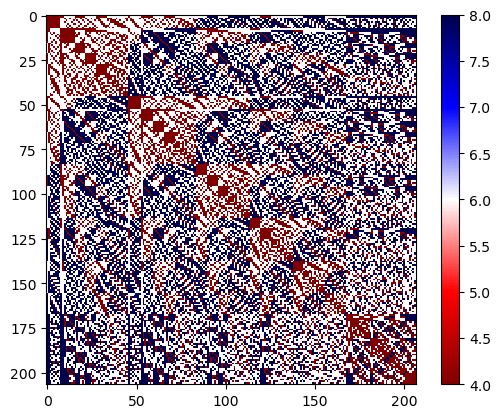

In [9]:
# check hamming distances
distmat = HammingDist_for_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(distmat, cmap='seismic_r', vmin=4, vmax=8, interpolation='nearest')
plt.colorbar()
plt.show()

In [10]:
# reduce map if necessary
reduced_design_barcodes = remove_bad_barcodes(design_barcodes, 
                                              min_hamming_dist=hamming_distance)
code_length = len(np.unique(reduced_design_barcodes))
print(code_length, len(reduced_design_barcodes))

minimum hamming distance: 2
2 207
minimum hamming distance: 2
2 206
minimum hamming distance: 2
2 205
minimum hamming distance: 2
2 204
minimum hamming distance: 2
2 203
minimum hamming distance: 2
2 202
minimum hamming distance: 2
2 201
minimum hamming distance: 2
2 200
minimum hamming distance: 2
2 199
minimum hamming distance: 2
2 198
minimum hamming distance: 2
2 197
minimum hamming distance: 2
2 196
minimum hamming distance: 4
18 195


In [11]:
195-178

17

# Select subset of possible codes

from MERFISH_probe_design.hamming_codes import code_selection, hamming_code_analysis
import MERFISH_probe_design.codebook_design.codebook_design_stochastic as cds
import MERFISH_probe_design.IO.file_io as fio

## optimization principles:
1. std of each

In [12]:
from tqdm import tqdm
# Initialize codes:

def _optimizer_group_stderr(_gene_group_df, _gene_code_df):
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    _optimizers = []
    for _group in _groups:
        _group_exp_df = _gene_group_df.loc[_gene_group_df['Group'] == _group, _valid_groups]
        _group_code_df = _gene_code_df.loc[_gene_group_df['Group'] == _group]
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_code_df.values).sum(0)
        _group_exp_stderr = np.std(_group_exp_vector) / np.mean(_group_exp_vector)
        _optimizers.append(_group_exp_stderr)
    return np.array(_optimizers)


def _group_bit_mean_exp(_gene_group_df, _gene_code_df):
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    _mean_exps = []
    for _group in _groups:
        _group_exp_df = _gene_group_df.loc[_gene_group_df['Group'] == _group, _valid_groups]
        _group_code_df = _gene_code_df.loc[_gene_group_df['Group'] == _group]
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_code_df.values).sum(0)
        _mean_exps.append(_group_exp_vector)
    return pd.DataFrame(_mean_exps, columns=_gene_code_df.columns, index=_groups)

def swap_code(gene_code_df, gene_group_df, i, j):
    _gene_code_df = gene_code_df.copy()
    _gene_code_df.iloc[i], _gene_code_df.iloc[j] =  _gene_code_df.iloc[j].copy(), _gene_code_df.iloc[i].copy()
    # compare optimizer:
    _old_optimizer = _optimizer_group_stderr(gene_group_df, gene_code_df)
    _new_optimizer = _optimizer_group_stderr(gene_group_df, _gene_code_df)
    if np.sum(_new_optimizer) - np.sum(_old_optimizer) < 0:
        return _gene_code_df
    else:
        return gene_code_df
    
def shuffle_group_codes(gene_code_df, gene_group_df, group, n_iters=100, verbose=False):
    # skip blank
    #if group.lower() == 'blank':
    #    return gene_code_df
    _group = group
    _gene_code_df = gene_code_df.copy()
    _groups, _group_sizes = np.unique(gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    # calculate current optimizer:
    _min_optimizer = _optimizer_group_stderr(gene_group_df, _gene_code_df)[list(_groups).index(_group)]
    if verbose:
        print(f"- shuffle group: Start={_min_optimizer:.5f}", end=', ')
    _group_codes = _gene_code_df.loc[gene_group_df['Group'] == _group].values # get current group_code
    _group_exp_df = gene_group_df.loc[gene_group_df['Group'] == _group, _valid_groups]
    for _iter in range(n_iters):
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_codes).sum(0)
        _group_exp_stderr = np.std(_group_exp_vector) / np.mean(_group_exp_vector)
        if np.isfinite(_group_exp_stderr) and _group_exp_stderr < _min_optimizer:
            #print(_iter, f"{_group_exp_stderr:.5f}")
            _min_optimizer = _group_exp_stderr
            _gene_code_df.loc[gene_group_df['Group'] == _group] = _group_codes
        # shuffle
        np.random.shuffle(_group_codes)
    if verbose:
        print(f"End={_min_optimizer:.5f} after {n_iters}-iters.")
    return _gene_code_df
    
    
def barcode_to_matrix(barcodes, num_bits=None):
    try:
        _num_bits = int(num_bits)
    except:
        _num_bits = max(len(np.unique(barcodes)), np.max(barcodes)+1)
    _matrix = np.zeros([len(barcodes), _num_bits], dtype=np.int32)
    for _i, _b in enumerate(barcodes):
        _matrix[_i][_b] = 1
    return _matrix
def generate_random_partition(candidate_codes, group_sizes):
    _codes = np.array(candidate_codes).copy()
    np.random.shuffle(_codes)
    _group_codes, _rest_codes = [], []
    _start = 0
    for _i, _gs in enumerate(group_sizes):
        _group_codes.append(_codes[_start:_start+_gs])
        _start += _gs
    # rest
    _rest_codes = _codes[_start:]
    return _group_codes, _rest_codes
    
    
    
def Select_optimized_barcodes(reduced_design_barcodes, kept_gene_df, 
                              shuffle_n_iters = 1000, swap_n_iters = 100, total_n_iters = 5,
                              verbose=True,
                              ):
    # Internalize params
    _candidate_barcodes = reduced_design_barcodes.copy()
    _candidate_codes = barcode_to_matrix(_candidate_barcodes)
    _num_bits = np.max(_candidate_barcodes) + 1 # assume barcode start as 1
    # group and expression
    _gene_group_df = kept_gene_df.copy()
    _mean_exp = np.mean(_gene_group_df[np.unique(_gene_group_df['Group'])].values)
    # append blank
    _blank_names = [f"blank-{_ib}" for _ib in range(len(_candidate_barcodes) - len(_gene_group_df))]
    _blank_group_df = pd.DataFrame(columns=_gene_group_df.columns, index=_blank_names)
    _blank_group_df['Group'] = 'blank'
    _gene_code_df = pd.DataFrame(columns=np.unique(_candidate_barcodes), index=list(_gene_group_df.index)+list(_blank_names)).fillna(0) 
    _gene_group_df = pd.concat([_gene_group_df, _blank_group_df], axis=0).fillna(_mean_exp/2)
    # find groups
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    #_valid_groups = [_g for _g in _groups if _g.lower() != 'blank']

    # random generate
    _group_codes_list, _rest_codes = generate_random_partition(_candidate_codes, _group_sizes)
    # first assign:
    for _group, _group_codes in zip(_groups, _group_codes_list):
        _gene_code_df.loc[_gene_group_df['Group'] == _group] = _group_codes
    # save init scores
    init_mean_exp_df = _group_bit_mean_exp(_gene_group_df, _gene_code_df)
    # print current status
    _init_optimizer = _optimizer_group_stderr(_gene_group_df, _gene_code_df)
    print(np.round(_init_optimizer, 5))
    
    for _total_iter in range(total_n_iters):
        # shuffle within groups
        for _group in _groups:
            _gene_code_df = shuffle_group_codes(_gene_code_df, _gene_group_df, _group, n_iters=shuffle_n_iters)
        # swap
        for _iter in tqdm(range(swap_n_iters)):
            _gene_code_df = swap_code(_gene_code_df, _gene_group_df, *np.random.randint(0, len(_gene_group_df), 2))
        # print current status
        _curr_optimizer = _optimizer_group_stderr(_gene_group_df, _gene_code_df)
        print(np.round(_curr_optimizer, 5))

    # final evaluation
    mean_exp_df = _group_bit_mean_exp(_gene_group_df, _gene_code_df)
    # return
    return _gene_group_df, _gene_code_df, init_mean_exp_df, mean_exp_df

In [13]:
_gene_group_df, _gene_code_df, init_mean_exp_df, mean_exp_df = \
    Select_optimized_barcodes(reduced_design_barcodes, 
                              kept_gene_df)

[1.09494 0.76409 0.81272 1.87083 0.49609 0.56418 0.54516 0.87427 0.64173
 0.48153]


100%|██████████| 100/100 [00:02<00:00, 37.31it/s]


[0.80327 0.48054 0.37246 1.87083 0.32826 0.45876 0.39441 0.65826 0.28006
 0.28284]


100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


[0.76771 0.47127 0.34813 1.87083 0.29681 0.43405 0.32666 0.57951 0.24137
 0.23979]


100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


[0.76171 0.35299 0.34665 1.87083 0.21421 0.44117 0.31171 0.26038 0.23912
 0.21506]


100%|██████████| 100/100 [00:02<00:00, 37.02it/s]


[0.75369 0.31032 0.30915 1.87083 0.2092  0.40874 0.31235 0.26002 0.23657
 0.18708]


100%|██████████| 100/100 [00:02<00:00, 37.97it/s]

[0.72538 0.29578 0.29395 1.87083 0.19302 0.38196 0.27037 0.25962 0.23134
 0.18708]


## Plot design criteria

In [14]:
_groups = np.unique(list(kept_gene_df['Group']) + ['blank'])

figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
import time
import seaborn as sns

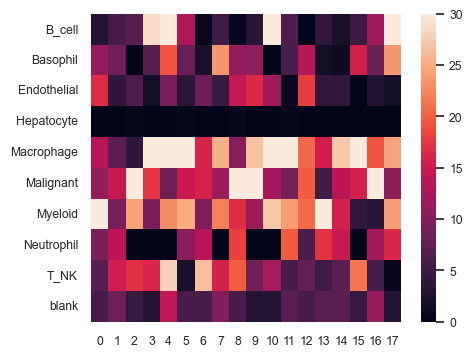

In [15]:
sns.set(font_scale=0.8) 
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
sns.heatmap(init_mean_exp_df,ax=ax, annot=False, annot_kws={'size': 3},
            yticklabels=_groups, vmin=0, vmax=30)
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_mean_exp_by_bit_init.png"), 
            transparent=True)
fig.show()

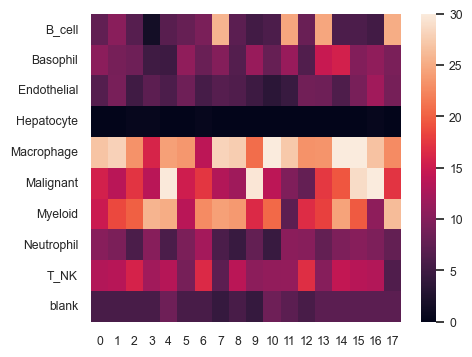

In [16]:
import seaborn as sns
sns.set(font_scale=0.8) 
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
sns.heatmap(mean_exp_df,ax=ax, annot=False, annot_kws={'size': 3},
            yticklabels=_groups, vmin=0, vmax=30)
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_mean_exp_by_bit_final.png"), 
            transparent=True)
fig.show()

In [17]:
# convert into standard format:
gene_codes, rest_codes = [], []
for _gene, _code in _gene_code_df.iterrows():
    if 'blank' not in _gene:
        gene_codes.append(np.where(_code.values)[0])
    else:
        rest_codes.append(np.where(_code.values)[0])

In [18]:
from MERFISH_probe_design.hamming_codes import code_selection, hamming_code_analysis

In [19]:
# select reasonable subset of rest_codes
# Select blank barcodes randomly
N_blank = 16
#np.random.shuffle(rest_codes)
#blank_codes = rest_codes[:N_blank]
blank_codes, _ = code_selection.find_subset_code_even_coverage(
    rest_codes, code_length, N_blank, N_rounds=1000)

Round = 1, variance = 0.24691358024691354
Round = 2, variance = 0.24691358024691354
Round = 3, variance = 0.24691358024691354
Round = 4, variance = 0.3580246913580246
Round = 5, variance = 0.24691358024691354
Round = 6, variance = 0.24691358024691354
Round = 7, variance = 0.24691358024691354
Round = 8, variance = 0.24691358024691354
Round = 9, variance = 0.24691358024691354
Round = 10, variance = 0.24691358024691354
Round = 11, variance = 0.3580246913580246
Round = 12, variance = 0.24691358024691354
Round = 13, variance = 0.24691358024691354
Round = 14, variance = 0.24691358024691354
Round = 15, variance = 0.3580246913580246
Round = 16, variance = 0.24691358024691354
Round = 17, variance = 0.24691358024691354
Round = 18, variance = 0.3580246913580246
Round = 19, variance = 0.24691358024691354
Round = 20, variance = 0.3580246913580246
Round = 21, variance = 0.3580246913580246
Round = 22, variance = 0.3580246913580246
Round = 23, variance = 0.24691358024691354
Round = 24, variance = 0.35

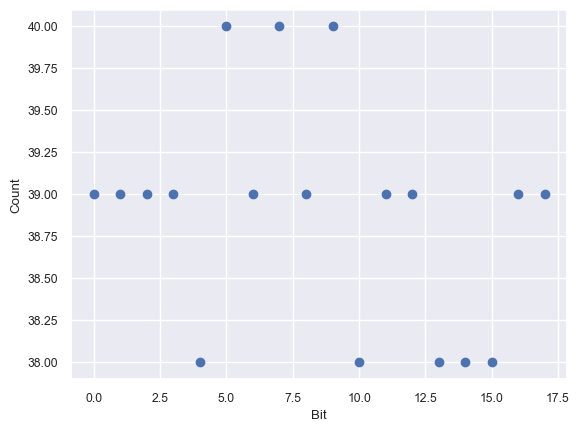

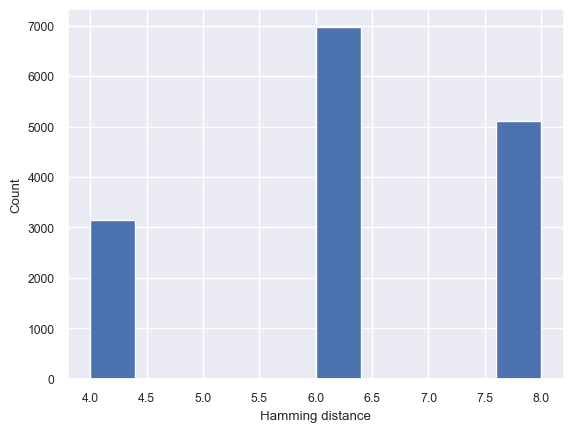

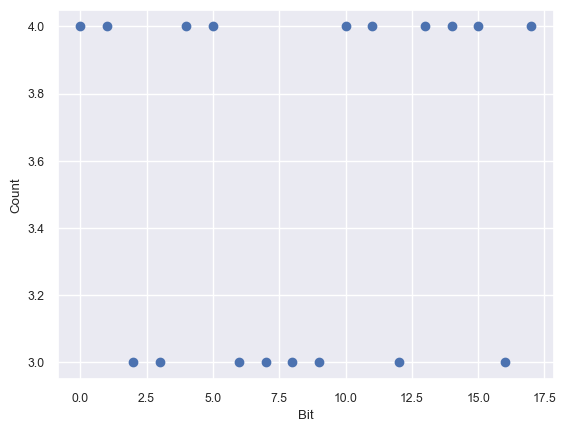

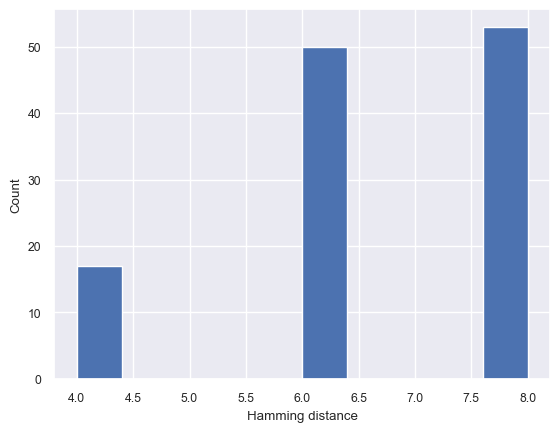

In [20]:
# Plot distributions of gene codes
hamming_code_analysis.plot_bit_coverage(gene_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(gene_codes)
# Plot distributions of blank codes
hamming_code_analysis.plot_bit_coverage(blank_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(blank_codes)

# Assign genes to bits

In [21]:
# Load the gene expressions for each cell cluster.
# This is a matrix of shape N_clusters x N_genes_of_interest.
# Each element is the expression level of a gene in a cluster.
cluster_gene_exp = kept_gene_df[np.unique(kept_gene_df['Group'])].transpose() #gene_mean_exp_df.values.transpose()
# Normalize the expressions, such that the sum of all expressions are N_clusters.
# The normalization is important for the subsequent simulated annealing.
cluster_gene_exp_normalized = cluster_gene_exp / np.sum(cluster_gene_exp) * cluster_gene_exp.shape[0]

In [22]:
# Load the cluster sizes
cluster_sizes = np.array([_ct['count'] for _type, _ct in celltype_num.iterrows() if _type in cluster_gene_exp.index])
# Log normalize the cluster sizes
cluster_sizes_log_normalized = np.log(cluster_sizes + 1) / np.sum(np.log(cluster_sizes + 1))

In [23]:
# Convert the gene codes to binary codes
import MERFISH_probe_design.codebook_design.codebook_design_stochastic as cds
gene_binary_codes = np.array([cds.on_bits_to_binary_code(c, code_length) for c in gene_codes])

In [24]:
gene_binary_codes.shape

(175, 18)

In [25]:
cluster_gene_exp.head()

Name,Trdc,Ighd,Klhl14,Tmem252,Gpr141,Dab2,Epcam,Msh2,Camk4,Themis,...,Fermt1,Plcb1,Cd300e,Fzd2,Tubb1,Il5,Rad51,Dll4,Itgb6,Snai1
B_cell,0.009607,1.507132,0.416594,0.000000,0.036099,0.006114,0.072780,0.123726,0.291703,0.206114,...,0.000000,0.066084,0.000582,0.000000,0.000291,0.002038,0.071325,0.004658,0.000000,0.027365
Basophil,0.013035,0.022346,0.005587,0.000000,0.141527,0.072626,0.016760,0.063315,0.059590,0.063315,...,0.000000,0.675978,0.000000,0.000000,0.000000,0.000000,0.033520,0.000000,0.001862,0.016760
Endothelial,0.018018,0.024024,0.000000,0.585586,0.201201,1.339339,0.006006,0.093093,0.210210,0.189189,...,0.003003,3.333333,0.012012,0.000000,0.003003,0.000000,0.030030,0.423423,0.000000,0.066066
Hepatocyte,0.000000,0.014085,0.000000,0.000000,0.084507,0.056338,0.000000,0.035211,0.105634,0.070423,...,0.007042,0.140845,0.000000,0.000000,0.000000,0.000000,0.035211,0.000000,0.000000,0.000000
Macrophage,0.002534,0.010453,0.002217,0.000000,0.584732,4.247387,0.065885,0.046563,0.031042,0.022490,...,0.000634,1.902439,0.008236,0.001584,0.004751,0.002217,0.015521,0.001901,0.002851,0.046563


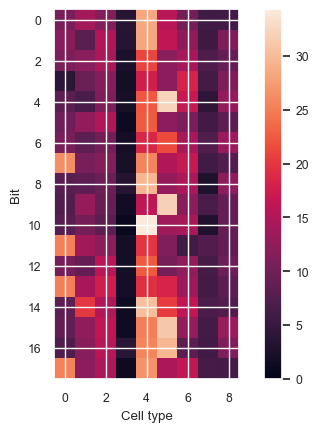

In [26]:
# Plot the distribution of numbers of bright dots in cells before optimization
# The values have the unit dot per million transcripts
cds.plot_dot_distribution(cluster_gene_exp, gene_binary_codes)

In [27]:
cluster_gene_exp_normalized.head()

Name,Trdc,Ighd,Klhl14,Tmem252,Gpr141,Dab2,Epcam,Msh2,Camk4,Themis,...,Fermt1,Plcb1,Cd300e,Fzd2,Tubb1,Il5,Rad51,Dll4,Itgb6,Snai1
B_cell,0.331586,8.513076,8.691026,0.000000,0.092336,0.007519,0.026710,0.821160,0.550345,0.459917,...,0.000000,0.037670,0.094044,0.000000,0.117574,0.243071,1.161913,0.095303,0.000000,0.443909
Basophil,0.449917,0.126224,0.116548,0.000000,0.362007,0.089323,0.006151,0.420214,0.112427,0.141279,...,0.000000,0.385324,0.000000,0.000000,0.000000,0.000000,0.546050,0.000000,0.152124,0.271870
Endothelial,0.621893,0.135700,0.000000,8.980526,0.514645,1.647268,0.002204,0.617850,0.396595,0.422152,...,0.021014,1.900083,1.940186,0.000000,1.212813,0.000000,0.489204,8.663426,0.000000,1.071695
Hepatocyte,0.000000,0.079557,0.000000,0.000000,0.216158,0.069291,0.000000,0.233694,0.199295,0.157139,...,0.049279,0.080285,0.000000,0.000000,0.000000,0.000000,0.573609,0.000000,0.000000,0.000000
Macrophage,0.087463,0.059044,0.046257,0.000000,1.495666,5.223906,0.024180,0.309035,0.058566,0.050183,...,0.004433,1.084437,1.330229,0.032348,1.918911,0.264475,0.252846,0.038886,0.232884,0.755328


In [28]:
%%time
# Optimize the code assigment to let cells have evenly distributed dots for each bit
# Use the log of cluster sizes to weight the divergence which we want to minimize
best_score, best_codes = cds.optimize_bit_assignments_simulated_annealing_parallel(
    cluster_gene_exp_normalized, cluster_sizes_log_normalized, gene_binary_codes,
    N_test=16, N_threads=16, N_rounds=1, N_iter=2000)

Simulated annealing finished with best score = 0.0.
Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.
Simulated annealing finished with best score = 0.0.
Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.

Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.
Simulated annealing finished with best score = 0.0.Simulated annealing finished with best score = 0.0.


Simulated annealing finished with best score = 0.0.

Simulated annealing finished with best score = 0.0.

Simulated annealing finished with best score = 0.0.


CPU times: user 57.9 ms, sys: 133 ms, total: 191 ms
Wall time: 19.4 s


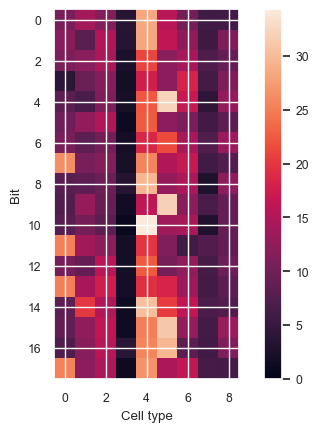

,cell_type_weights
0,0.148306
1,0.130029
2,0.123365
3,0.122087
4,0.120013
5,0.097687
6,0.095271
7,0.088048
8,0.075195


In [29]:
# The dot distribution is better now.
# There are vertical strip patterns that our optimization didn't change. 
# This is because we can only optimize the distribution across bits.
# The total number of bright dots for each cell type is always 4 x N_expressed_transcripts.
cds.plot_dot_distribution(cluster_gene_exp, best_codes)

# Note that dots in some of the cell types with few cells are not very evenly distributed
pd.DataFrame({'cell_type_weights': cluster_sizes_log_normalized})

# load readouts

In [30]:
from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame

readout_folder = r'/lab/solexa_weissman/puzheng/References/Readouts'
readout_filename = os.path.join(readout_folder, 'updated_Stvs.fasta')
print(f"Loading readouts from file: {readout_filename}")
readouts_all = load_fasta_to_DataFrame(readout_filename)
# select
start_bit = 22
readouts = readouts_all[start_bit:start_bit+num_bits]
readouts.loc[:,'Name'] = np.array([_n.split(' ')[0] for _n in readouts['Name']])
#print(readouts)
readouts_names = list(readouts['Name'])

Loading readouts from file: /lab/solexa_weissman/puzheng/References/Readouts/updated_Stvs.fasta


In [31]:
readouts, readouts_names

(      Name                        Sequence
 22  Stv_29  ACTCGTTTAACGGCCGGTTGGTCTACGGAT
 23  Stv_30  GGGTACTCGCGTCTGGAACGACGGATTCAG
 24  Stv_31  AACATCGGATCGGTGCGGTGGGATGGATAA
 25  Stv_32  AGACGACGCACGTTCGTACCGCGTACTTCG
 26  Stv_33  TTTGCTCGCAAGTGCGCACGAGTTGAACTG
 27  Stv_35  AGTTTCCATACGCGGCGTGAATATCGCGGC
 28  Stv_36  GCTACAGCGTTACGGGCCCAGACGTTTCAT
 29  Stv_37  TTTATCGTGCGTGTCCGCCAGTACCGTGAG
 30  Stv_39  CGTGCGGGAACCGTATCCCTGGCGCGGACT
 31  Stv_40  AATCCGGCGTACGTAAGGCAGCTTGCGTTA
 32  Stv_42  GCGGGATTCGTACGAGCCCTCTTGGACGGG
 33  Stv_44  CTTTGTTCGGCTCGGAGCGTTACTGCGGGC
 34  Stv_45  TAATTCCGGTATCGGGCCCTTTTGTCTGAC
 35  Stv_46  CGTGAGAATGCGTCGCGATACTGGTGTAAG
 36  Stv_48  TCTCATGGTCGCCGGACCGTGATGCCGTGT
 37  Stv_50  GCCATGGTACGACGGCAAGAGAGCGTGCGT
 38  Stv_53  ACACCCGATACGTCGTGGGACGTGGACCGT
 39  Stv_54  CGACGATGATCGCAATCGGAGAACTACACC,
 ['Stv_29',
  'Stv_30',
  'Stv_31',
  'Stv_32',
  'Stv_33',
  'Stv_35',
  'Stv_36',
  'Stv_37',
  'Stv_39',
  'Stv_40',
  'Stv_42',
  'Stv_44',
  'Stv_45',
  'Stv_

## Save readout file

In [32]:
# save readouts
readout_savefile = os.path.join(library_folder, 'readouts.csv')
print(f"Saving readouts to file: {readout_savefile}")
readouts.to_csv(readout_savefile, index=None)

Saving readouts to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/readouts.csv


## Save codebook

In [33]:
len(kept_gene_df), len(best_codes)

(175, 175)

In [34]:
import MERFISH_probe_design.IO.file_io as fio
# Get a list of gene names including the blank barcodes
gene_names = list(kept_gene_df.index.values) + [f'Blank-{i + 1}' for i in range(N_blank)]

# Get a list of transcript names including the blank barcodes
gene_2_transcript = {_gene:_transcript for _gene, _transcript in kept_gene_df['Transcript'].items()}
transcript_names = [gene_2_transcript[_g] for _g in list(kept_gene_df.index.values)] + [f'' for i in range(N_blank)]

# Convert the barcodes into strings of '1' and '0'.
barcode_binarys = list(best_codes) + [cds.on_bits_to_binary_code(c, code_length) for c in blank_codes]
barcode_strings  = [''.join([str(b) for b in c]) for c in barcode_binarys]

# Write the codebook
print(f"Saving codebook to file: {codebook_file}")
fio.write_merlin_codebook(codebook_file, '1.0', 'MF9-mf4plus', readouts_names, gene_names, transcript_names, barcode_strings)

Saving codebook to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/codebook.csv


## Manually check codebook now!